In [ ]:
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time

In [ ]:
# Загружаем данные MNIST без преобразований (только ToTensor)
transform = transforms.Compose([
    transforms.ToTensor()  # Преобразует изображение в тензор
])

# Загружаем тренировочный датасет
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Создаем DataLoader для итерации по данным
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)

# Инициализируем переменные для вычисления среднего и std
mean = 0.0
std = 0.0
total_samples = 0

# Вычисляем среднее
for images, _ in train_loader:
    batch_samples = images.size(0)  # Количество изображений в батче
    images = images.view(batch_samples, images.size(1), -1)  # Преобразуем в [batch_size, channels, height*width]
    mean += images.mean(2).sum(0)  # Суммируем среднее по всем изображениям в батче
    total_samples += batch_samples

mean /= total_samples  # Делим на общее количество изображений

# Вычисляем стандартное отклонение
for images, _ in train_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    std += ((images - mean.unsqueeze(1)) ** 2).sum([0, 2])  # Суммируем квадраты отклонений

std = torch.sqrt(std / (total_samples * 28 * 28))  # Делим на общее количество пикселей

print("Mean:", mean.item())
print("Std:", std.item())

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 36.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.23MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.71MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Mean: 0.13066041469573975
Std: 0.30810797214508057


In [ ]:
# Определяем модель
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Преобразуем изображение в вектор
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Преобразования для данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Загружаем данные
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
# Инициализация модели, функции потерь и оптимизатора
model = FCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Компиляция модели с torch.compile()
compiled_model = torch.compile(model) #

# Функция для обучения
def train(model, train_loader, criterion, optimizer, device='cpu', compiled=False):
    model.to(device)
    model.train()
    total_loss = 0
    start_time = time.time()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    end_time = time.time()
    print(f"Compiled: {compiled}, Loss: {total_loss / len(train_loader)}, Time: {end_time - start_time:.4f} seconds")

# Обучение без компиляции
print("Без использования torch.compile():")
train(model, train_loader, criterion, optimizer, device='cpu', compiled=False)

# Обучение с компиляцией
# torch._dynamo.reset()
print("С использованием torch.compile() default:")
train(compiled_model, train_loader, criterion, optimizer, device='cpu', compiled=True)
print("С использованием torch.compile() reduce-overhead:")
compiled_model = torch.compile(model, mode="reduce-overhead")
train(compiled_model, train_loader, criterion, optimizer, device='cpu', compiled=True)
print("С использованием torch.compile() max-autotune:")
compiled_model = torch.compile(model, mode="max-autotune")
train(compiled_model, train_loader, criterion, optimizer, device='cpu', compiled=True)

Без использования torch.compile():
Compiled: False, Loss: 0.2649670912941763, Time: 21.4231 seconds
С использованием torch.compile() default:


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


Compiled: True, Loss: 0.10939310731858745, Time: 65.1584 seconds
С использованием torch.compile() reduce-overhead:
Compiled: True, Loss: 0.07865439395882937, Time: 18.4633 seconds
С использованием torch.compile() max-autotune:
Compiled: True, Loss: 0.059115262584202785, Time: 18.3187 seconds


In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # поставить cuda:0
print(f"Using device: {device}")

Using device: cpu


In [ ]:
model = FCNN().to(device)

In [ ]:
# Загружаем данные
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)

In [ ]:
# train(model, train_loader, criterion, optimizer, device=device, compiled=False)
# compiled_model = torch.compile(model)
# train(compiled_model, train_loader, criterion, optimizer, device=device, compiled=True)
# compiled_model = torch.compile(model, mode="reduce-overhead")
# train(compiled_model, train_loader, criterion, optimizer, device=device, compiled=True)
# compiled_model = torch.compile(model, mode="max-autotune")
# train(compiled_model, train_loader, criterion, optimizer, device=device, compiled=True)

на gpu прирост прозводительности для такой модели не является существенным

Шедуллинг (scheduling) в PyTorch

Training with scheduler:
Epoch [1/10], Loss: 0.2697, LR: 0.001000
Epoch [2/10], Loss: 0.1144, LR: 0.001000
Epoch [3/10], Loss: 0.0801, LR: 0.001000
Epoch [4/10], Loss: 0.0632, LR: 0.001000
Epoch [5/10], Loss: 0.0482, LR: 0.000100
Epoch [6/10], Loss: 0.0234, LR: 0.000100
Epoch [7/10], Loss: 0.0171, LR: 0.000100
Epoch [8/10], Loss: 0.0147, LR: 0.000100
Epoch [9/10], Loss: 0.0129, LR: 0.000100
Epoch [10/10], Loss: 0.0112, LR: 0.000010
Training without scheduler:
Epoch [1/10], Loss: 0.0390, LR: 0.001000
Epoch [2/10], Loss: 0.0320, LR: 0.001000
Epoch [3/10], Loss: 0.0297, LR: 0.001000
Epoch [4/10], Loss: 0.0247, LR: 0.001000
Epoch [5/10], Loss: 0.0207, LR: 0.001000
Epoch [6/10], Loss: 0.0229, LR: 0.001000
Epoch [7/10], Loss: 0.0184, LR: 0.001000
Epoch [8/10], Loss: 0.0189, LR: 0.001000
Epoch [9/10], Loss: 0.0173, LR: 0.001000
Epoch [10/10], Loss: 0.0158, LR: 0.001000


/usr/local/lib/python3.11/dist-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.11/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


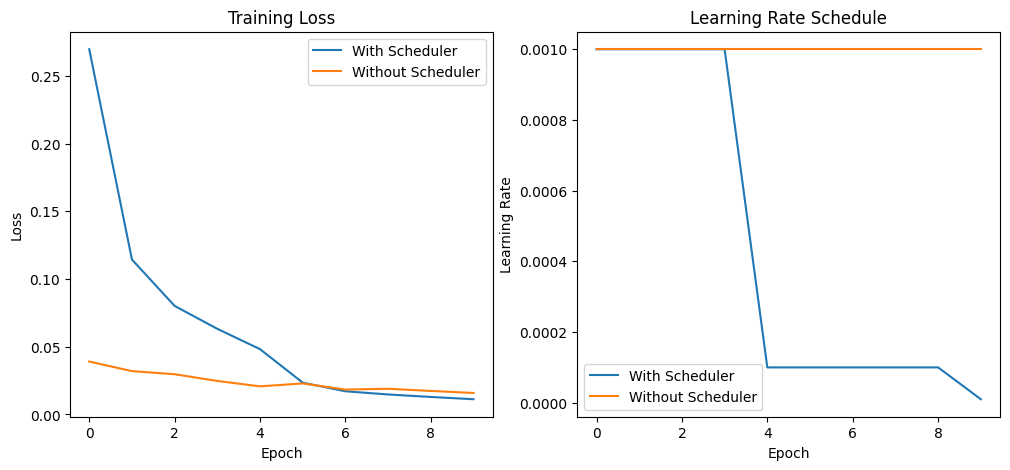

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Определяем модель
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Преобразуем изображение в вектор
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Загрузка данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Инициализация модели, функции потерь и оптимизатора
model = FCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Шедуллер для уменьшения скорости обучения
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Уменьшаем LR каждые 5 эпох в 10 раз

# Функция для обучения
def train(model, train_loader, criterion, optimizer, scheduler=None, num_epochs=10):
    model.train()
    losses = []
    learning_rates = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        if scheduler:
            scheduler.step()  # Обновляем скорость обучения

        losses.append(epoch_loss / len(train_loader))
        learning_rates.append(optimizer.param_groups[0]['lr'])  # Сохраняем текущий LR
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}, LR: {learning_rates[-1]:.6f}")

    return losses, learning_rates

# Обучаем модель с шедуллером
print("Training with scheduler:")
losses_with_scheduler, lrs_with_scheduler = train(model, train_loader, criterion, optimizer, scheduler, num_epochs=10)

# Обучаем модель без шедуллера (для сравнения)
optimizer_no_scheduler = optim.Adam(model.parameters(), lr=0.001)
print("Training without scheduler:")
losses_without_scheduler, lrs_without_scheduler = train(model, train_loader, criterion, optimizer_no_scheduler, num_epochs=10)

# Визуализация результатов
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(losses_with_scheduler, label='With Scheduler')
plt.plot(losses_without_scheduler, label='Without Scheduler')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# График скорости обучения
plt.subplot(1, 2, 2)
plt.plot(lrs_with_scheduler, label='With Scheduler')
plt.plot(lrs_without_scheduler, label='Without Scheduler')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()

plt.show()

In [ ]:
# Уменьшает скорость обучения, если потери перестают улучшаться.
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# Изменяет скорость обучения по косинусоидальному закону.
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Использует одну циклическую политику изменения скорости обучения.
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, total_steps=100)

Модуль хуков в PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Хук — это функция, которая будет вызываться во время прямого или обратного прохода. Например, можно создать хук для сохранения активаций сверточного слоя:

In [ ]:
# описание хука
activations = {}
def hook_fn(module, input, output):
    activations['conv1'] = output

In [ ]:
model = CNN()
# регистрация хука
hook_handle = model.conv1.register_forward_hook(hook_fn) # регистрация хука

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(1):  # 1 эпоха для наглядности
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}')
            print(f'Activations: {activations["conv1"].shape}')

Epoch: 0, Batch: 0, Loss: 2.289372205734253
Activations: torch.Size([64, 32, 28, 28])
Epoch: 0, Batch: 100, Loss: 0.4008307158946991
Activations: torch.Size([64, 32, 28, 28])
Epoch: 0, Batch: 200, Loss: 0.08166441321372986
Activations: torch.Size([64, 32, 28, 28])
Epoch: 0, Batch: 300, Loss: 0.09684998542070389
Activations: torch.Size([64, 32, 28, 28])
Epoch: 0, Batch: 400, Loss: 0.1251658797264099
Activations: torch.Size([64, 32, 28, 28])
Epoch: 0, Batch: 500, Loss: 0.0785474181175232
Activations: torch.Size([64, 32, 28, 28])
Epoch: 0, Batch: 600, Loss: 0.13533729314804077
Activations: torch.Size([64, 32, 28, 28])
Epoch: 0, Batch: 700, Loss: 0.006346864625811577
Activations: torch.Size([64, 32, 28, 28])
Epoch: 0, Batch: 800, Loss: 0.025149695575237274
Activations: torch.Size([64, 32, 28, 28])
Epoch: 0, Batch: 900, Loss: 0.07552441209554672
Activations: torch.Size([64, 32, 28, 28])


In [ ]:
# можем видеть как изменялся тензор сигнала с выхода слоя activations["conv1"]